## Gaussian Klustering

## Gaussian Mixture Models for Unsupervised Learning

In [1]:
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn import mixture
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import loadingADHD_Data
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

%matplotlib inline



## Loading Patients Data 

In [2]:
# 1. Load data using the imported script loadingA 

path_dataV2 = path = "/Users/and_ma/Documents/DataScience/UB_DataScience/DataScience_Project/UB_Features_V2/"
patientsDF = loadingADHD_Data.load(path_dataV2)

ApatientsDF = patientsDF[patientsDF['experiment']=='A']
dropApatientsDF = ApatientsDF.drop(['experiment', 'patientName'],1)
BpatientsDF = patientsDF[patientsDF['experiment']=='B']
dropBpatientsDF = BpatientsDF.drop(['experiment', 'patientName'],1)
CpatientsDF = patientsDF[patientsDF['experiment']=='C']
dropCpatientsDF = CpatientsDF.drop(['experiment', 'patientName'],1)
dropPatientsDF = patientsDF.drop(['experiment','patientName'],1)
numberA = len(patientsDF[patientsDF['experiment']=='A'])
numberB = len(patientsDF[patientsDF['experiment']=='B'])
numberC = len(patientsDF[patientsDF['experiment']=='C'])


In [3]:
dropApatientsDF.shape

(68, 64)

## Calculating PCA for Multidimentional representation

In [4]:
### Do the PCA decomposition! for the sake of visualisation, only 3 components are considered
pca = PCA(n_components=2)
newdataPCA = pca.fit_transform(dropPatientsDF.values)  # concatenates vectors row by row
print ("PCA performs well with 2 componets, variance of two componets : ",np.sum(pca.explained_variance_ratio_))
pca.explained_variance_ratio_

PCA performs well with 2 componets, variance of two componets :  0.898206462617


array([ 0.83619435,  0.06201211])

## Calculating GMM
For this task two functions are defined.

In [5]:
def getBestGMM(X,n_components,cv_types):
    
    '''
    Function that finds the best GMM cluster trying different gaussians and 
    different number of clusters
    X:input data
    n_components: Number of components
    cv_types: types of gaussians 
    '''
    
    lowest_bic = np.infty
    bic = []
    silhouette = []
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            Y_predicted=gmm.predict(X)
            if cv_type =='tied':
                silhouette.append(metrics.silhouette_score(X, Y_predicted,  metric='euclidean'))
                #I only save the values for tied, because i know from the first run that its the best gaussian
            if n_components>=1:
                if bic[-1] < lowest_bic:
                    lowest_bic = bic[-1]
                    best_gmm = gmm
                    
    bic = np.array(bic)
    color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm','y'])
    return best_gmm,color_iter,bic,silhouette

def plotBIC_Scores(color_iter,n_components,cv_types,bic):
    # Function used for ploting of the gmm 
    spl = plt.subplot(1, 1, 1)
    bars = []
    
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
                            
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('Bayesian Information Criteria score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)   



### Calculating GMM for group A patients


Best sillhouette A patients  0.246620696374


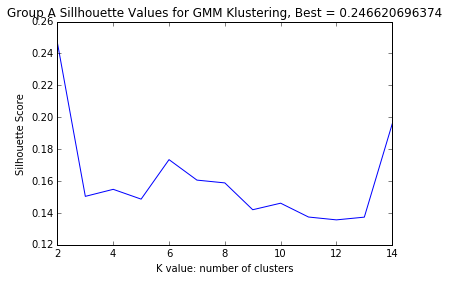

In [6]:
### 1. Get best model for A patients
X_A = dropApatientsDF.values

#### Normalising data
scaler = StandardScaler()
X_A = scaler.fit_transform(X_A)
n_components_range = range(2,15)
cv_types = ['spherical', 'tied', 'diag', 'full']
clf_A,color_iter,bic,silhouette_A = getBestGMM(X_A,n_components_range,cv_types)  

### 2. Save the Clf winner results
Y_A = clf_A.predict(X_A)
# Very interesting clf_A.predict_proba(X_A), it gives back the actual likelihood


# Value metrics silhouette score
best_A = metrics.silhouette_score(X_A, Y_A,  metric='euclidean')
print ("Best sillhouette A patients ",best_A)

### 3. Plotting sillhouette for cluster A
plt.figure() 
plt.plot(np.arange(2,15),np.array(silhouette_A),color='b')
plt.title("Group A Sillhouette Values for GMM Klustering, Best = %s"%(best_A))
plt.xlabel("K value: number of clusters")
plt.ylabel("Silhouette Score")

### Ploting the GMM clusters with PCA 2 components 

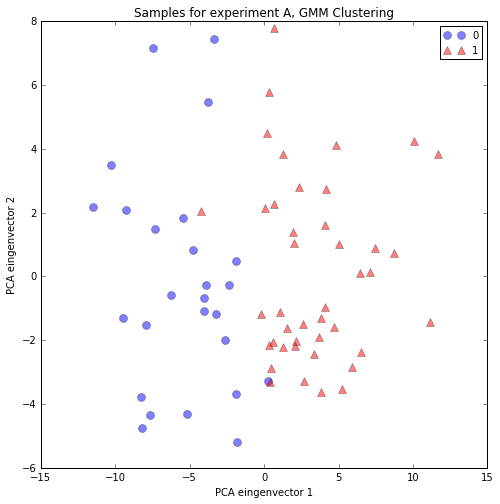

In [7]:
### 4. Ploting GMM clustering result using PCA Components
pca = PCA(n_components=2)
newdataPCA_A = pca.fit_transform(X_A)  # concatenates vectors row by row

plotApatientsGMM = ApatientsDF.copy() 
plotApatientsGMM['PCA_x'] = newdataPCA_A.T[0]
plotApatientsGMM['PCA_y'] = newdataPCA_A.T[1]
plotApatientsGMM['cluster'] = Y_A

plotApatientsGMM.sort_values(by='cluster', ascending= True, inplace=True) # Dataframe is sorted by cluster type: 0 or 1

### Indexes for ploting
number1 = len(plotApatientsGMM[plotApatientsGMM['cluster']==0])
number2 = len(plotApatientsGMM[plotApatientsGMM['cluster']==1])

### Plot result clustering in two dimensions
fig = plt.figure(figsize=(8,8))
plt.rcParams['legend.fontsize'] = 10
plt.plot(plotApatientsGMM['PCA_x'].values[0:number1], plotApatientsGMM['PCA_y'].values[0:number1], 'o', markersize=8, color='blue', alpha=0.5, label='0')
plt.plot(plotApatientsGMM['PCA_x'].values[number1:], plotApatientsGMM['PCA_y'].values[number1:], '^', markersize=8, alpha=0.5, color='red', label='1')
plt.xlabel('PCA eingenvector 1')
plt.ylabel('PCA eingenvector 2')
plt.title('Samples for experiment A, GMM Clustering')
plt.legend(loc='upper right')
plt.show()

plotApatientsGMM.to_csv('gmmApatients.csv', sep=',', encoding='utf-8')
###################################### END Patients A

### Ploting the GMM A clusters with TSNE 

In [8]:
from sklearn.manifold import TSNE

model_tsne = TSNE(n_components=2, random_state=0)
Y_A_TSNE = model_tsne.fit_transform(X_A)
print('TSNE Calculated')

TSNE Calculated


/anaconda/envs/PycharmEnv/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


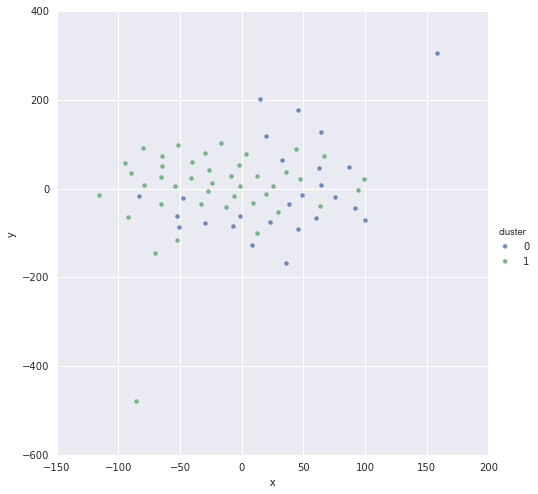

In [9]:
import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
for i in range(Y_A_TSNE.shape[0]):
    data["x"].append(Y_A_TSNE[i][0])
    data["y"].append(Y_A_TSNE[i][1])
    data["cluster"].append(Y_A[i])

df = pd.DataFrame(data)


sns.lmplot("x", "y", data=df,
           fit_reg=False, size=7,
           hue="cluster", legend=True)

plt.show()


### Calculating GMM for group B patients


Best sillhouette B patients  0.195702904139


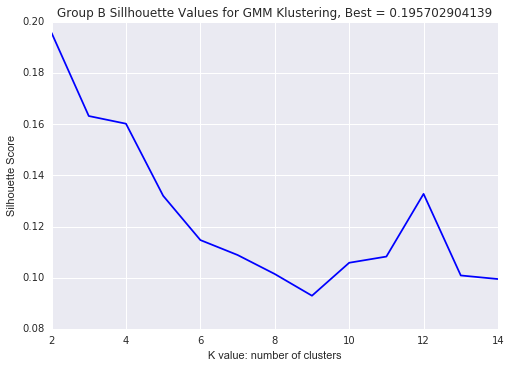

In [10]:
### 1. Get best model for B patients
X_B = dropBpatientsDF.values
scaler = StandardScaler()
X_B = scaler.fit_transform(X_B)

n_components_range = range(2,15)
cv_types = ['spherical', 'tied', 'diag', 'full']
clf_B,color_iter,bic,silhouette_B = getBestGMM(X_B,n_components_range,cv_types)  
### 2. Save the Clf winner results
Y_B= clf_B.predict(X_B)

# Value metrics silhouette score 
best_B = metrics.silhouette_score(X_B, Y_B,  metric='euclidean')
print ("Best sillhouette B patients ",best_B)

### 3. Plotting sillhouette for cluster B
plt.figure() 
plt.plot(np.arange(2,15),np.array(silhouette_B),color='b')
plt.title("Group B Sillhouette Values for GMM Klustering, Best = %s"%best_B)
plt.xlabel("K value: number of clusters")
plt.ylabel("Silhouette Score")


### Ploting the GMM clusters with PCA 2 components 

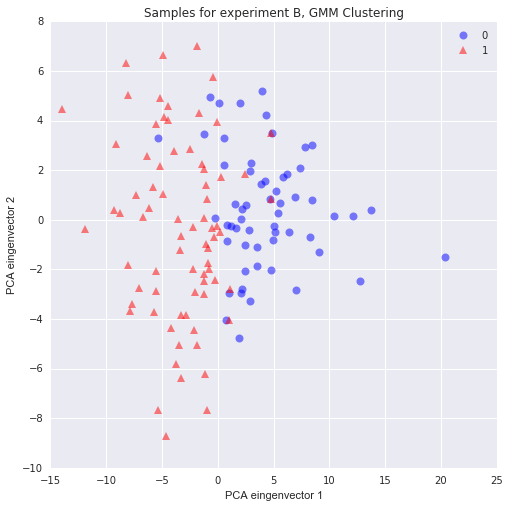

In [11]:

### 4. Ploting GMM clustering result using PCA Components
pca = PCA(n_components=2)
newdataPCA_B = pca.fit_transform(X_B)  # concatenates vectors row by row
pca.explained_variance_ratio_
plotBpatientsGMM = BpatientsDF.copy()
plotBpatientsGMM['PCA_x'] = newdataPCA_B.T[0]
plotBpatientsGMM['PCA_y'] = newdataPCA_B.T[1]
plotBpatientsGMM['cluster'] = Y_B

plotBpatientsGMM.sort_values(by='cluster', ascending= True, inplace=True) # Dataframe is sorted by cluster type: 0 or 1

### Indexes for ploting
number1 = len(plotBpatientsGMM[plotBpatientsGMM['cluster']==0])
number2 = len(plotBpatientsGMM[plotBpatientsGMM['cluster']==1])

### Plot result clustering in two dimensions
fig = plt.figure(figsize=(8,8))
plt.rcParams['legend.fontsize'] = 10
plt.plot(plotBpatientsGMM['PCA_x'].values[0:number1], plotBpatientsGMM['PCA_y'].values[0:number1], 'o', markersize=8, color='blue', alpha=0.5, label='0')
plt.plot(plotBpatientsGMM['PCA_x'].values[number1:], plotBpatientsGMM['PCA_y'].values[number1:], '^', markersize=8, alpha=0.5, color='red', label='1')
plt.xlabel('PCA eingenvector 1')
plt.ylabel('PCA eingenvector 2')
plt.title('Samples for experiment B, GMM Clustering')
plt.legend(loc='upper right')
plt.show()
plotBpatientsGMM.to_csv('gmmBpatients.csv', sep=',', encoding='utf-8')

### Ploting the GMM C clusters with TSNE

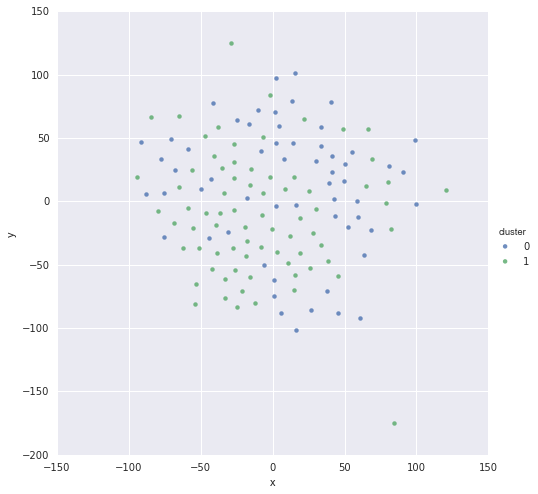

In [12]:
from sklearn.manifold import TSNE

model_tsne = TSNE(n_components=2, random_state=0)
Y_B_TSNE = model_tsne.fit_transform(X_B)

import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
for i in range(Y_B_TSNE.shape[0]):
    data["x"].append(Y_B_TSNE[i][0])
    data["y"].append(Y_B_TSNE[i][1])
    data["cluster"].append(Y_B[i])

df = pd.DataFrame(data)


sns.lmplot("x", "y", data=df,
           fit_reg=False, size=7,
           hue="cluster", legend=True)

plt.show()

### Calculating GMM for group C patients


Best sillhouette C patients  0.213967973294


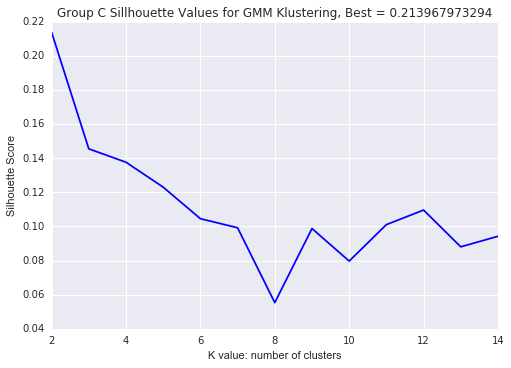

In [13]:
### 1. Get best model for A patients
X_C = dropCpatientsDF.values
# Normalising
scaler = StandardScaler()
X_C = scaler.fit_transform(X_C)

n_components_range = range(2,15)
cv_types = ['spherical', 'tied', 'diag', 'full']
clf_C,color_iter,bic,silhouette_C = getBestGMM(X_C,n_components_range,cv_types)  

### 2. Save the Clf winner results
Y_C = clf_C.predict(X_C)

# Value metrics silhouette score 
best_C = metrics.silhouette_score(X_C, Y_C,  metric='euclidean')
print ("Best sillhouette C patients ",best_C)

### 3. Plotting sillhouette for cluster A
plt.figure() 
plt.plot(np.arange(2,15),np.array(silhouette_C),color='b')
plt.title("Group C Sillhouette Values for GMM Klustering, Best = %s"%best_C)
plt.xlabel("K value: number of clusters")
plt.ylabel("Silhouette Score")


### Ploting the GMM clusters with PCA 2 components 

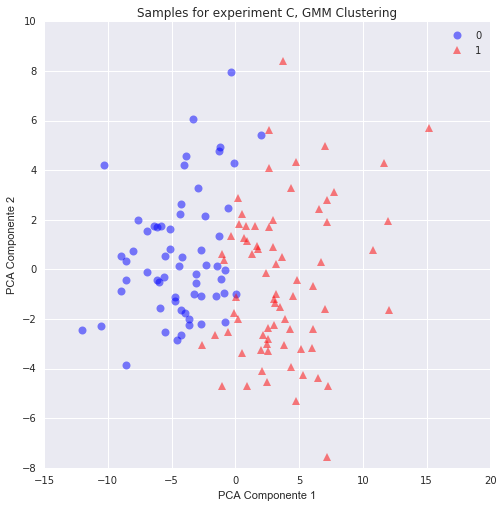

In [14]:
### 4. Ploting GMM clustering result using PCA Components
pca = PCA(n_components=3)
newdataPCA_C = pca.fit_transform(X_C)  # concatenates vectors row by row
pca.explained_variance_ratio_
plotCpatientsGMM = CpatientsDF.copy()
plotCpatientsGMM['PCA_x'] = newdataPCA_C.T[0]
plotCpatientsGMM['PCA_y'] = newdataPCA_C.T[1]
plotCpatientsGMM['cluster'] = Y_C

plotCpatientsGMM.sort_values(by='cluster', ascending= True, inplace=True) # Dataframe is sorted by cluster type: 0 or 1
### Indexes for ploting
number1 = len(plotCpatientsGMM[plotCpatientsGMM['cluster']==0])
number2 = len(plotCpatientsGMM[plotCpatientsGMM['cluster']==1])

### Plot result clustering in two dimensions
fig = plt.figure(figsize=(8,8))
plt.rcParams['legend.fontsize'] = 10
plt.plot(plotCpatientsGMM['PCA_x'].values[0:number1], plotCpatientsGMM['PCA_y'].values[0:number1], 'o', markersize=8, color='blue', alpha=0.5, label='0')
plt.plot(plotCpatientsGMM['PCA_x'].values[number1:], plotCpatientsGMM['PCA_y'].values[number1:], '^', markersize=8, alpha=0.5, color='red', label='1')
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.title('Samples for experiment C, GMM Clustering')
plt.legend(loc='upper right')
plt.show()
plotCpatientsGMM.to_csv('gmmCpatients.csv', sep=',', encoding='utf-8')



### Ploting the GMM c clusters with TSNE

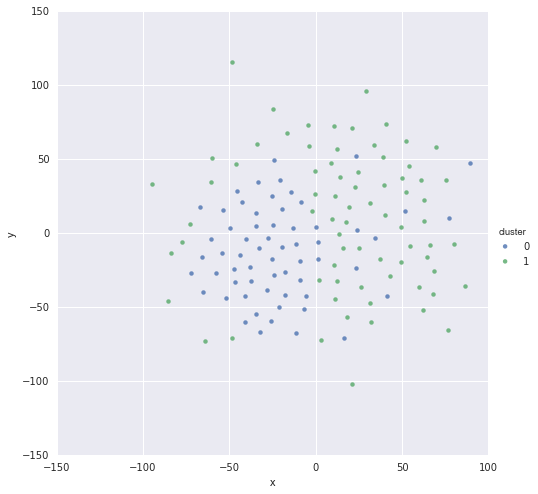

In [15]:
from sklearn.manifold import TSNE

model_tsne = TSNE(n_components=2, random_state=0)
Y_C_TSNE = model_tsne.fit_transform(X_C)

import pandas as pd
import seaborn as sns

data = {"x": [], "y": [], "cluster": []}
for i in range(Y_C_TSNE.shape[0]):
    data["x"].append(Y_C_TSNE[i][0])
    data["y"].append(Y_C_TSNE[i][1])
    data["cluster"].append(Y_C[i])

df = pd.DataFrame(data)


sns.lmplot("x", "y", data=df,
           fit_reg=False, size=7,
           hue="cluster", legend=True)

plt.show()

In [16]:
plotCpatientsGMM.shape
plotCpatientsGMM


,Fp1_(Theta2+Alpha1),Fp1_(Theta),Fp1_(Alpha),Fp1_(Beta_Global),Fp1_(Beta_Alta),Fp1_(Beta_Baja),Fp1_(Gamma),F3_(Theta2+Alpha1),F3_(Theta),F3_(Alpha),...,BPR_Fz,BPR_Cz,BPR_Fp2,BPR_F4,BPR_C4,patientName,experiment,PCA_x,PCA_y,cluster
200,1.358850,1.890351,1.170497,0.832836,0.893174,0.650941,0.823612,1.696721,2.751039,1.495408,...,6.818379,10.122223,6.497796,5.334638,6.903169,S110_C,C,-2.670518,0.780789,0
286,1.806440,2.562019,1.258246,0.822831,0.662367,0.703407,0.591365,2.175749,2.760519,1.422316,...,3.854611,5.828029,2.071495,3.973873,2.581587,S34_C,C,-7.991876,0.759825,0
284,1.692427,2.747962,1.478987,0.868871,0.558756,0.839098,0.459108,1.913277,3.270832,1.616239,...,3.554498,4.444303,2.965604,2.483138,2.520372,S32_C,C,-7.602404,2.004196,0
283,1.274728,2.226918,0.907890,1.026317,0.755229,0.950160,0.689826,1.621012,2.678940,1.224232,...,5.814399,14.629472,2.371304,6.361196,11.906775,S38_C,C,-4.419456,0.126610,0
281,1.975248,2.699796,1.172043,0.887314,0.585512,0.902761,0.531609,1.453021,1.988925,1.278840,...,8.047757,12.371096,6.472641,6.713211,2.167649,S31_C,C,-4.182095,0.478048,0
280,1.633205,2.415085,1.037060,1.071220,0.759831,0.814899,0.656845,2.079938,2.977657,1.347783,...,4.799154,8.402015,2.554449,3.231992,6.920922,S30_C,C,-6.170602,1.721602,0
279,1.223268,1.772967,0.786814,1.102584,0.845190,1.003218,0.793307,1.054746,1.205727,0.736586,...,3.540010,8.559936,0.000000,1.729656,6.979878,S26_C,C,-8.967325,0.552101,0
275,1.398416,2.357113,0.817774,1.005324,0.853945,0.749223,0.743026,1.983644,3.881991,1.150761,...,6.581345,7.358923,3.250749,3.078396,6.719600,S20_C,C,-3.958373,-1.751944,0
271,1.867113,2.962013,1.572496,0.728435,0.572996,0.621338,0.468231,2.104682,3.418128,1.863531,...,3.164080,5.277483,1.959263,5.190971,4.020357,S48_C,C,-2.906269,3.292963,0
270,2.094865,2.702950,1.462264,0.882786,0.505713,0.915136,0.449419,2.259576,2.996891,1.568503,...,7.679706,8.569368,3.516571,4.582135,7.600993,S14_C,C,-4.303909,2.234007,0
